## Introduction: Computationally Sampling Bradley-Terry

Given a preference interval $\mathbf u$ Bradley-Terry (BT) is a model for
drawing ballots when generating elections (TODO: insert link here).
In particular, `name_Bradley_Terry.generate_profile()` is a method
which, when given a preference interval, list of candidates and a number of ballots,
samples a profile of ballots according to the Bradley-Terry
distribution.  

In votekit today, sampling BT profiles is done by computing the probability mass function on
the set of ballots and then drawing from this pmf a single ballot at a
time. However, this involves computing $n!$ terms and
then storing all $n!$ probabilities. Using this method would mean that
Votekit is only able to support BT generative elections with up $11$
candidates. In this notebook we detail and investigate a Markov Chain
Monte Carlo approach which allows us to effectively simulate BT
elections with more than $30$ candidates and more than $1,000,000$
ballots.

### Imports and Helper functions

In [3]:
# adjust the directory so that we can import local source
# NOTE: this should probably be adjust or removed in the final
# version, depending on "read the docs" compiles
import sys
import os

# Add the repo root to sys.path
ROOT_REL_PATH_FROM_NB = "../.."
repo_path = os.path.abspath(os.path.join(os.getcwd(), ROOT_REL_PATH_FROM_NB))  # adjust as needed
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

print(sys.path)

from src.votekit.ballot_generator import name_BradleyTerry 
from src.votekit.pref_interval import PreferenceInterval
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from math import factorial

['/home/willithg/MGGG/VoteKit', '/home/willithg/miniconda3/lib/python312.zip', '/home/willithg/miniconda3/lib/python3.12', '/home/willithg/miniconda3/lib/python3.12/lib-dynload', '', '/home/willithg/miniconda3/lib/python3.12/site-packages']


In [4]:
classic_colour = "blue"
non_shortcut_colour = "orange"
shortcut_colour = "green"

def total_variation_distance(P, Q, labels):
    sum = 0 
    for x in labels:
        sum += abs(P[x] - Q[x])
    return (1/2)*sum

def generate_BT_args(n_cands, alpha=1):
    '''
        generates arguments for name_BradleyTerry class
        with n_cands, generates single slate and single bloc.
    '''
    if n_cands == 0:
        raise Exception("cannot generate BT args for 0 candidates")

    #cands = [chr(ord('a')+i) for i in range(n_cands)] # alphabetic candidates
    cands = [f"Cand{i}" for i in range(n_cands)]
    bloc_name = "H"
    pref_interval = PreferenceInterval.from_dirichlet(candidates=cands, alpha=alpha)
    pref_intervals_by_bloc = {
        bloc_name: {
            bloc_name : pref_interval
        }
    }
    bloc_voter_prop = {bloc_name: 1}
    cohesion_paramteters = {
        bloc_name: {
            bloc_name: 1
        }
    }
    
    return {
        "candidates": cands,
        "pref_intervals_by_bloc": pref_intervals_by_bloc,
        "bloc_voter_prop" : bloc_voter_prop,
        "cohesion_parameters": cohesion_paramteters
    }

def get_pdf_from_BT_instance(bt_inst):
    '''
        Given an instance of `name_BradleyTerry` this method returns
        the bt-pdf stored on the instance
    '''
    blocs = bt_inst.blocs
    if len(blocs) != 1:
        raise Exception("Non-one bloc on bt_inst")
    return bt_inst.pdfs_by_bloc[blocs[0]]


def get_ballot_labels_and_weights(profile):
    '''
    Given a preference profile, collects the ballots and weights into
    a dictionary (Ranking as tuple : weight).
    '''
    ballot_rankings = [bal.ranking for bal in profile.ballots]
    ## convert the rankings from tuple of frozen sets into tuple of strings
    bal_labels = [tuple([list(cand)[0] for cand in ranking]) for ranking in ballot_rankings]
    bal_weights = [int(bal.weight) for bal in profile.ballots]

    return dict(zip(bal_labels, bal_weights))

## Comparing MCMC on Different Ballot Graphs

The method described in (TODO: link to general section) will also work
on any regular graph whose nodes are valid ballots. In particular
there are two commonly (citation?) used ballot graphs. Previously we
have defined two ballots to be adjacent if they differe by a single
neighbour swap. We can define the *shortcut ballot graph* by extending
this and defining two edges to be adjacent if they differ by a swap of
any two candidates. If our score function is the same as previously
defined then Metropolis-Hastings on the shortcut ballot graph still
has Bradley-Terry as a stationary distribution. 

In this section we will run some experiements comparing
Metropolois-Hastings on the two different kinds of Ballot graph.

### Comparing TV distance to BT Pdf

In the following cell we generate BT profiles by continuously sampled
MH on the shortcut and non-shortcut ballot graph. We do this on a
small enough set of candidates so that we can directly compute the
exact pdf. We then compare the TV distance between each sampled
profile to the known distribution.

In [9]:
total_ballots = 10_000
num_ballots_array = np.linspace(100, total_ballots, 100)
num_ballots_array = num_ballots_array.astype(int)[1:]
num_trials_per_ballot_size = 10

N_CANDS_FOR_BALLOTS = 6
bt = name_BradleyTerry(**generate_BT_args(n_cands=N_CANDS_FOR_BALLOTS, alpha=1))
bt_pdfs = get_pdf_from_BT_instance(bt)

tv_distances_non_shortcut = []
tv_distances_shortcut = []
tv_distances_classic = []
for num_ballots in tqdm(num_ballots_array):
    running_total_non_shortcut = 0
    running_total_shortcut = 0
    running_total_classic = 0
    for _ in range(num_trials_per_ballot_size):
        ## -- Intialize the ballots ------------ 
        bals_BT_MCMC = bt.generate_profile_MCMC(num_ballots).group_ballots()
        bals_BT_MCMC_shortcut = bt.generate_profile_MCMC(num_ballots, on_shortcut_graph=True).group_ballots() 
        bals_BT_classic = bt.generate_profile(num_ballots).group_ballots()

        ## -- Calculate the frequencies ----------------
        bal_rankings_map_classic_as_freq = {
            ballot : weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_classic).items()
        }
        bal_rankings_map_mcmc_as_freq = {
            ballot: weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_MCMC).items()
        }
        bal_rankings_map_mcmc_shortcut_as_freq = {
            ballot: weight/num_ballots for ballot, weight in get_ballot_labels_and_weights(bals_BT_MCMC_shortcut).items()
        }

        # populate any ballots that were not sampled
        all_keys = bt_pdfs.keys()
        for key in all_keys:
            bal_rankings_map_classic_as_freq.setdefault(key, 0)
            bal_rankings_map_mcmc_as_freq.setdefault(key, 0)
            bal_rankings_map_mcmc_shortcut_as_freq.setdefault(key, 0)
        
        # increment the recorded tv distances
        running_total_non_shortcut += total_variation_distance(bal_rankings_map_mcmc_as_freq, bt_pdfs, list(all_keys))
        running_total_shortcut += total_variation_distance(bal_rankings_map_mcmc_shortcut_as_freq, bt_pdfs, list(all_keys))
        running_total_classic += total_variation_distance(bal_rankings_map_classic_as_freq, bt_pdfs, list(all_keys))

    tv_distances_non_shortcut.append(running_total_non_shortcut/num_trials_per_ballot_size)
    tv_distances_shortcut.append(running_total_shortcut/num_trials_per_ballot_size)
    tv_distances_classic.append(running_total_classic/num_trials_per_ballot_size)

100%|██████████| 99/99 [20:24<00:00, 12.36s/it]


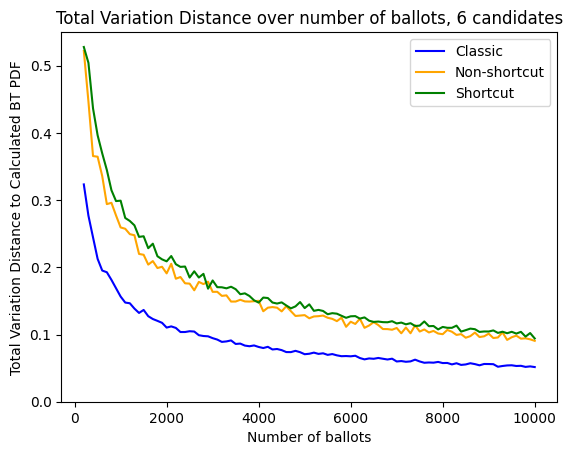

In [20]:
### Plot TV Distance as a function of ballots
plt.plot(num_ballots_array, tv_distances_classic, label="Classic", color = classic_colour)
plt.plot(num_ballots_array, tv_distances_non_shortcut, label="Non-shortcut", color = non_shortcut_colour)
plt.plot(num_ballots_array, tv_distances_shortcut, label="Shortcut", color = shortcut_colour)
plt.ylim(0, 0.55)
plt.legend()
plt.xlabel("Number of ballots")
plt.ylabel(f"Total Variation Distance to Calculated BT PDF")
plt.title(f"Total Variation Distance over number of ballots, {N_CANDS_FOR_BALLOTS} candidates")
plt.show()

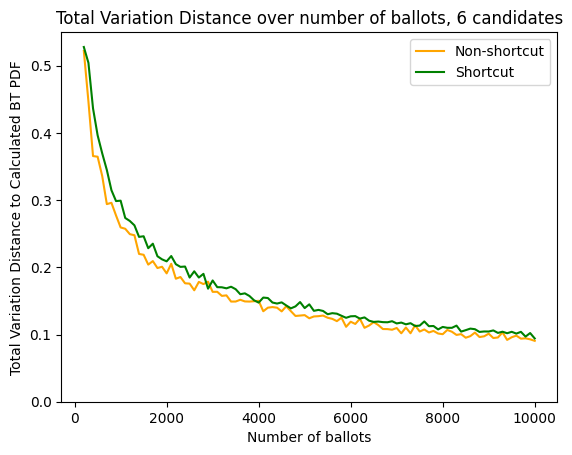

In [21]:
plt.plot(num_ballots_array, tv_distances_non_shortcut, label="Non-shortcut", color=non_shortcut_colour)
plt.plot(num_ballots_array, tv_distances_shortcut, label="Shortcut", color=shortcut_colour)
plt.ylim(0, 0.55)
plt.legend()
plt.xlabel("Number of ballots")
plt.ylabel(f"Total Variation Distance to Calculated BT PDF")
plt.title(f"Total Variation Distance over number of ballots, {N_CANDS_FOR_BALLOTS} candidates")
plt.show()

### INSERT Conclusion

## Comparing Run Times and Memory Usage

The primary issue with the classic method was that it required
$\mathcal O(\# \text{ cands})$ space and run-time. For each of our
Metropolis-Hastings methods, we require only $\mathcal O(\# \text{
ballots})$ space and $\mathcal O (n)$ computations per step of the
markov chain. With subsampling the number of steps that we run our
Markov chains goes like $\mathcal O (k)$ and so the runtime of our
Metropolis-Hastings method requires about $\mathcal O(nk)$ run time.
For Metropolis-Hastings on the shortcut graph we instead have $\binom{n}{2}$
scores to compute and so our asymptotic runtime becomes $\mathcal O
(n^2k)$, at the benefit of having a more connected underyling graph
which, in theory, may lead to faster mixing. In this section we run
some experiments to measure the empirical runtime and memory usage of
each method

In [5]:
bt_5_cands = name_BradleyTerry(**generate_BT_args(n_cands=5, alpha=1))
n_ballots = 1_000_000
print("Classic time:")
%timeit -n 1 -r 1 bt_5_cands.generate_profile(n_ballots)
print("MCMC time:")
%timeit -n 1 -r 1 bt_5_cands.generate_profile_MCMC(n_ballots)

Classic time:


KeyboardInterrupt: 

In [ ]:
# 20 candidates run time sampling
bt_20_cands = name_BradleyTerry(**generate_BT_args(n_cands=20, alpha=1))
n_ballots = 1_000_000
# The Classic method cannot run with this many candidates
print("MCMC on non-shortcut graph time:") 
#%timeit -n 1 -r 1 bt_20_cands.generate_profile_MCMC(n_ballots)
bt_20_cands.generate_profile_MCMC(n_ballots)
print("MCMC on shortcut graph time:")
#%timeit -n 1 -r 1 bt_20_cands.generate_profile_MCMC(n_ballots, on_shortcut_graph=True)

/home/willithg/MGGG/VoteKit/src/votekit/ballot_generator.py:834: UserWarning: For 12 or more candidates, exact sampling is computationally infeasible.                     Please only use the built in generate_profile_MCMC method.
  warnings.warn(


MCMC on non-shortcut graph time:


In [ ]:
import warnings

'''
    Collect run time data for all methods at various candidate sizes
'''

#x_pts = [5, 7, 8, 9, 10, 25, 50, 100, 200, 300] #500]#1000]
cand_sizes = range(5, 30)
N_BALLOTS = 1000

classic_times = []
mcmc_times = [-1 for _ in cand_sizes]
mcmc_shortcut_times = [-1 for _ in cand_sizes]

warnings.filterwarnings("ignore") # due to existing bug in group_ballots() with large number of candidates

for i in tqdm(range(len(cand_sizes))):
    n_cands_i = cand_sizes[i]
    i_bt = name_BradleyTerry(**generate_BT_args(n_cands=n_cands_i, alpha=1))
    if n_cands_i < 11:
        time_classic = %timeit -o -q -n 5 -r 1 i_bt.generate_profile(N_BALLOTS)
        classic_times.append(time_classic.average)
    else:
        classic_times.append(np.inf)
        

    time_mcmc = %timeit -o -q -n 5 -r 1 i_bt.generate_profile_MCMC(N_BALLOTS)
    time_mcmc_shortcut = %timeit -o -q -n 5 -r 1 i_bt.generate_profile_MCMC(N_BALLOTS, on_shortcut_graph=True)
    mcmc_times[i] = time_mcmc.average
    mcmc_shortcut_times[i] = time_mcmc_shortcut.average

print(classic_times)
print(mcmc_times)
print(mcmc_shortcut_times)

warnings.resetwarnings()

In [ ]:
plt.plot(cand_sizes, classic_times, label="classic", marker="o")
plt.plot(cand_sizes, mcmc_times, label="mcmc", marker=".")
plt.plot(cand_sizes, mcmc_shortcut_times, label="mcmc shortcut", marker="v")
plt.xlabel("Num of Candidates")
plt.ylabel("Run time (s)")
plt.title(f"Runtime of BT methods, {N_BALLOTS} ballots")
plt.legend()